In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [86]:
from sklearn.model_selection import train_test_split

In [87]:
MLB_DF = pd.read_csv('MLB_INPUT.csv')

In [88]:
MLB_DF['home_ISO'] = MLB_DF['home_SLG'] - MLB_DF['home_AVG']
MLB_DF['away_ISO'] = MLB_DF['away_SLG'] - MLB_DF['away_AVG']
MLB_DF['ISO_difference'] = MLB_DF['home_ISO'] - MLB_DF['away_ISO']
MLB_DF['ISO_difference_PCT'] = (MLB_DF['home_ISO'] - MLB_DF['away_ISO'])/ MLB_DF['home_ISO']*100

In [89]:
MLB_DF.head()

,dt,Y,M,D,away_team,home_team,away_pitcher_id,home_pitcher_id,outcome,home_AVG,...,home_ELO,away_ELO,ELO_difference,E[ELO],home_rest,away_rest,home_ISO,away_ISO,ISO_difference,ISO_difference_PCT
0,2001-04-01,2001,4,1,TEX,TOR,hellr001,loaie001,1,0.273459,...,1496.828252,1462.450742,34.377511,0.597675,5,5,0.192927,0.161597,0.031331,16.239572
1,2001-04-02,2001,4,2,SLN,COL,kiled001,hampm001,1,0.290176,...,1487.470945,1529.964302,-42.493357,0.380077,5,5,0.158088,0.182953,-0.024866,-15.729076
2,2001-04-02,2001,4,2,SDN,SFN,willw001,hernl003,1,0.276079,...,1544.173611,1478.296302,65.877309,0.681015,5,5,0.192446,0.146424,0.046022,23.914199
3,2001-04-02,2001,4,2,MIL,LAN,wrigj001,parkc002,1,0.254198,...,1527.653270,1509.946671,17.706599,0.550788,5,5,0.172233,0.156534,0.015699,9.115030
4,2001-04-02,2001,4,2,ATL,CIN,burkj001,harnp001,0,0.272199,...,1544.192550,1512.406489,31.786061,0.590480,5,5,0.171600,0.155356,0.016244,9.466322


Grouping into Years

In [90]:
def create_features(data, pct = True):
    features = data.drop(labels = 
                       ['dt', 'Y', 'M', 'D', 'away_team', 
                        'home_team', 'away_pitcher_id', 'home_pitcher_id',
                       'date'],
                      axis = 1)
    features['rest_difference'] = features['home_rest'] - features['away_rest']
    features['ELO_difference_PCT'] = features['ELO_difference']/features['home_ELO']*100
    if (pct == True):
        PCT_DIFF = features[[i for i in list(features) if 'PCT' in i] + ['rest_difference', 'outcome']]
        PCT_DIFF_features = [i for i in list(features) if 'PCT' in i] + ['rest_difference']
        return PCT_DIFF[PCT_DIFF_features], PCT_DIFF['outcome']
    else:
        DIFF = features[[i for i in list(features) if 
                         (('difference' in i) and ('PCT' not in i))] + ['outcome']]
        DIFF_features = [i for i in list(features) if 
                        (('difference' in i) and ('PCT' not in i))] + []
        return DIFF[DIFF_features], DIFF['outcome']

In [91]:
def seasonal_train_test_split(X, Y):
    test_train_cutoff = int(len(X)*.75)
    x_train = X[0:test_train_cutoff]
    x_test = X[test_train_cutoff:]
    y_train = Y[0:test_train_cutoff]
    y_test = Y[test_train_cutoff:]
    
    return x_train, x_test, y_train, y_test

In [92]:
def create_yearly_samples(MLB_DF = MLB_DF):
    years = list(set(MLB_DF.Y))
    YEARLY_DATA = {}
    for i in years:
        YEARLY_MLB = create_features(MLB_DF[MLB_DF.Y == i])
        x_train, x_test, y_train, y_test = seasonal_train_test_split(YEARLY_MLB[0], YEARLY_MLB[1])
        YEARLY_DATA[i] = {
            'x_train': x_train,
            'x_test': x_test,
            'y_train': y_train,
            'y_test': y_test
        }
    return YEARLY_DATA

In [93]:
features = create_features(MLB_DF)
X, Y = features[0], features[1]

Brief EDA

In [94]:
import numpy as np
np.corrcoef([1 if x > .5 else 0 for x in MLB_DF['E[ELO]']], MLB_DF['outcome'])

array([[1.        , 0.08780784],
       [0.08780784, 1.        ]])

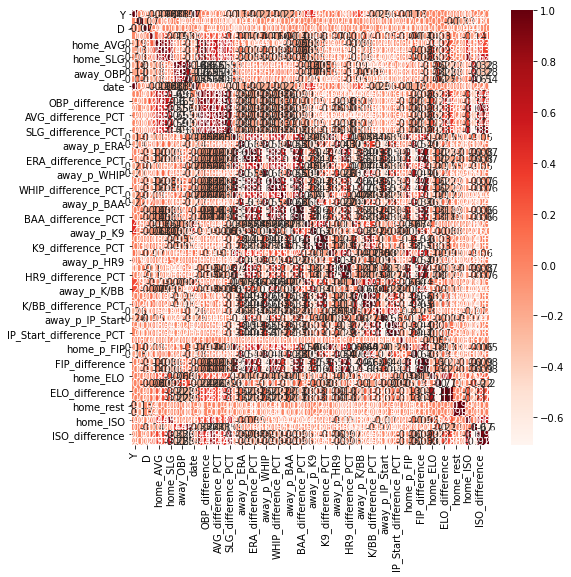

In [95]:
plt.figure(figsize=(8,8))
cor = MLB_DF.corr()
cor = cor.apply(lambda x: round(100*x)/100)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

In [96]:
cor_target = abs(cor['ISO_difference'])

relevant_features = cor_target[cor_target >= 0.2]
relevant_features

outcome               0.21
home_AVG              0.32
home_OBP              0.33
home_SLG              0.62
away_AVG              0.32
away_OBP              0.32
away_SLG              0.61
AVG_difference        0.46
OBP_difference        0.46
SLG_difference        0.90
AVG_difference_PCT    0.46
OBP_difference_PCT    0.46
SLG_difference_PCT    0.88
home_ELO              0.22
away_ELO              0.22
ELO_difference        0.31
E[ELO]                0.31
home_ISO              0.68
away_ISO              0.67
ISO_difference        1.00
ISO_difference_PCT    0.92
Name: ISO_difference, dtype: float64

Train Test Split

In [97]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size = 0.2, random_state = 499
)

In [98]:
x_train.describe()

,AVG_difference_PCT,OBP_difference_PCT,SLG_difference_PCT,ERA_difference_PCT,WHIP_difference_PCT,BAA_difference_PCT,K9_difference_PCT,HR9_difference_PCT,K/BB_difference_PCT,IP_Start_difference_PCT,FIP_difference_PCT,ISO_difference_PCT,ELO_difference_PCT,rest_difference
count,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000,36902.000000
mean,-1.013753,-0.353648,-1.762579,-4.849463,-1.543917,-0.964437,-4.599433,-9.545156,-12.651959,-0.619514,-3.057202,-7.650092,-0.045809,0.005176
std,17.394966,14.730360,22.250893,32.257533,16.939803,13.697813,32.949782,50.064237,62.970650,12.485722,25.116845,46.460539,3.148565,2.497672
min,-109.282700,-83.205575,-157.825203,-229.100529,-106.690676,-84.831461,-442.874564,-666.666667,-1160.035842,-203.648952,-273.291994,-661.572052,-12.576655,-182.000000
25%,-11.173356,-9.246454,-14.403381,-21.088191,-11.130426,-8.914729,-21.186172,-29.928126,-35.845792,-6.986513,-15.756292,-28.386657,-2.133602,0.000000
50%,0.394479,0.643160,0.537893,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.023691,0.036315,0.000000
75%,10.908716,9.717416,13.513514,17.018699,9.750654,8.064374,17.361554,22.738554,27.086232,6.690210,13.231119,23.186105,2.119065,0.000000
max,54.131151,45.784566,58.864957,76.251788,54.100310,47.337278,75.327746,86.907083,92.063718,70.064800,69.855852,86.970515,12.373090,189.000000


In [99]:
x_test.describe()

,AVG_difference_PCT,OBP_difference_PCT,SLG_difference_PCT,ERA_difference_PCT,WHIP_difference_PCT,BAA_difference_PCT,K9_difference_PCT,HR9_difference_PCT,K/BB_difference_PCT,IP_Start_difference_PCT,FIP_difference_PCT,ISO_difference_PCT,ELO_difference_PCT,rest_difference
count,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000,9226.000000
mean,-0.918526,-0.392223,-1.848003,-3.630164,-0.882540,-0.785439,-4.769428,-8.412165,-15.190001,-1.052978,-2.081860,-8.143427,-0.102615,-0.019185
std,17.488899,14.844921,22.720465,31.326347,16.843149,13.645209,32.823776,48.669140,63.517387,12.541143,24.245362,47.733615,3.153391,1.842221
min,-100.687467,-80.906050,-173.263305,-190.000000,-98.916667,-72.580645,-279.736025,-540.506329,-721.088435,-155.025126,-142.324217,-690.004131,-12.576655,-175.000000
25%,-10.729833,-9.278354,-14.664288,-19.411060,-10.799806,-8.800000,-21.449948,-27.760155,-39.240801,-7.505054,-14.883281,-29.501492,-2.226193,0.000000
50%,0.499993,0.621195,0.701127,0.000000,0.000000,0.000000,0.000000,0.000000,-0.129454,0.000000,0.000000,0.761052,-0.049613,0.000000
75%,10.896330,9.752750,13.716618,17.981224,10.476884,8.246499,17.582884,23.234190,25.983309,6.435782,14.007017,23.403565,2.064447,0.000000
max,51.130637,45.409988,57.058195,68.118467,48.746199,42.580645,72.634819,81.203008,84.416882,63.636011,67.616483,81.968811,11.307956,4.000000


Models
Logistic Regression First

In [100]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import math

In [101]:
X = features[0]
Y = features[1]

In [102]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = 0.80, random_state = 499)

In [103]:
logit = LogisticRegression(
    penalty = 'l2', 
    fit_intercept = True,
    random_state = 499, 
)

In [104]:
logit.fit(x_train, y_train)
logit.score(x_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6369031488808194

In [105]:
scores = cross_val_score(logit, x_train, y_train, cv=10)
print("Accuracy: %0.3f (+/- %0.3f)" % (
    scores.mean(), scores.std() * 2))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Accuracy: 0.636 (+/- 0.010)


In [106]:
sum(logit.predict(x_test) == y_test)/len(y_test)

0.6348363321049209

In [107]:
def compute_logit_probabilities(logit, x_test):
    logit_probs = [math.exp(x)/(1 + math.exp(x)) for x in list((logit.decision_function(x_test)))]
    return logit_probs

def compute_lift_probabilities(x_test_probs, y_test, bin_width = 0.05):
    '''
    bin_width is probability increments
    '''
    
    y_pred = pd.DataFrame(dict(zip(logit_probs, y_test)), 
                 index = ['y']).T.reset_index().rename({'index': 'yhat'}, axis = 1)
    y_pred['buckets'] = y_pred['yhat'].apply(lambda x: round(x/bin_width)*bin_width)
    return y_pred

In [109]:
x_train, x_test, y_train, y_test = seasonal_train_test_split(X, Y)

In [110]:
logit.fit(x_train, y_train)
logit.score(x_train, y_train)


0.6365475777546538

In [111]:
scores = cross_val_score(logit, x_train, y_train, cv=5)
print("Accuracy: %0.3f (+/- %0.3f)" % (
    scores.mean(), scores.std() * 2))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Accuracy: 0.636 (+/- 0.014)


In [112]:
logit_probs = [math.exp(x)/(1 + math.exp(x)) for x in list((logit.decision_function(x_test)))]
y_pred = compute_lift_probabilities(logit_probs, y_test, bin_width = 0.03)
y_pred.groupby('buckets')['y'].count()

buckets
0.03      7
0.06     17
0.09     38
0.12     48
0.15    101
0.18    126
0.21    163
0.24    203
0.27    276
0.30    304
0.33    337
0.36    432
0.39    496
0.42    573
0.45    633
0.48    718
0.51    682
0.54    764
0.57    767
0.60    765
0.63    704
0.66    714
0.69    615
0.72    548
0.75    473
0.78    352
0.81    289
0.84    194
0.87    102
0.90     60
0.93     20
0.96      9
Name: y, dtype: int64

LogisticCV

In [114]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import brier_score_loss, confusion_matrix, \
    roc_auc_score, roc_curve, auc, average_precision_score, precision_score

In [115]:
X, Y = create_features(MLB_DF, False)
x_train, x_test, y_train, y_test = seasonal_train_test_split(X, Y) # why standrardscale when you couldn't?


# x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = 0.75, random_state = 499)
logitCV = LogisticRegressionCV(cv = 6, random_state = 499)

In [116]:
logitCV.fit(x_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegressionCV(cv=6, random_state=499)

In [117]:
logitCV.score(x_test, y_test)

0.6358827610128338

In [118]:
logit_probs = [math.exp(x)/(1 + math.exp(x)) for x in list((logitCV.decision_function(x_test)))]
brier_score_loss(y_test, logit_probs)

0.22295440454515092

In [119]:
confusion_matrix(y_test, logitCV.predict(x_test))

array([[2939, 2442],
       [1757, 4394]])

In [120]:
roc_auc_score(y_test, logitCV.predict(x_test))

0.6302681983076529

In [121]:
fpr, tpr, thresholds = roc_curve(y_test, logit_probs)

0.6852406229146545


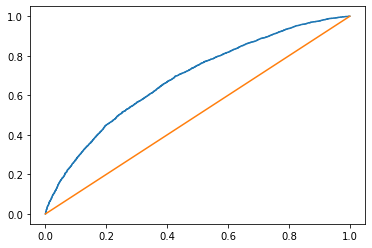

In [122]:
print(auc(fpr, tpr))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])

In [123]:
average_precision_score(y_test, logit_probs)

0.7011589397195774

In [124]:
precision_score(y_test, logitCV.predict(x_test))

0.6427735517846694